In [1]:
cd ..

/Users/lisawink/Documents/freiburg


In [2]:
import geopandas as gpd
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import calc_params
import altair as alt
from mpl_toolkits.mplot3d import Axes3D
alt.data_transformers.enable("vegafusion")
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import warnings

warnings.filterwarnings('ignore')

In [3]:
temp =  pd.read_csv('/Users/lisawink/Documents/paper1/data/gap_filled_data_ta_rh.csv')
temp['datetime_UTC']=pd.to_datetime(temp['datetime_UTC'])
temp = temp[temp['variable']=='Ta_deg_C']
temp['datetime_UTC'] = temp['datetime_UTC'].astype(str)
temp = temp.pivot(index='station_id', columns='datetime_UTC', values='value')

In [4]:
hiwn = pd.read_csv('/Users/lisawink/Documents/paper1/data/processed_data/heat_island_winter_nights.csv')

In [5]:
# Define station IDs
stations = ['FRASHA', 'FRBETZ', 'FRBRUH', 'FRDREI', 'FRFRIE', 'FRGART', 'FRGLBA',
            'FRGUNT', 'FRHAID', 'FRHBHF', 'FRHERD', 'FRHOLZ', 'FRIHOC', 'FRINST',
            'FRKART', 'FRLAND', 'FRLORE', 'FRMESS', 'FROWIE', 'FRPDAS', 'FRRIES',
            'FRSEEP', 'FRSTGA', 'FRSTGE', 'FRSTUH', 'FRUNIK', 'FRUWIE', 'FRVAUB',
            'FRWEIN', 'FRWSEE', 'FRZAHR']

# Create a colormap (e.g., using the 'tab20' color palette)
cmap = plt.get_cmap('tab20', len(stations))  # 31 unique colors
station_colors = {station: cmap(i) for i, station in enumerate(stations)}  # Map station to color


In [24]:
var

'StrClo400_median'

In [28]:
radius = 500

In [39]:
vars = gpd.read_parquet(f'/Users/lisawink/Documents/paper1/data/processed_data/processed_station_params_{radius}.parquet')
vars.index = vars['station_id']
to_remove = ['station_id','station_no','station_name','station_long_name','station_type','station_lat','station_lon','station_elevation','mounting_structure','sky_view_factor','dominant_land_use','local_climate_zone','urban_atlas_class','urban_atlas_code','geometry','SVF']
vars = vars.drop(to_remove, axis=1)
vars = vars.merge(temp, left_on='station_id', right_on='station_id',how='inner')

std = vars[var].std()
mean = vars[var].mean()
cv = std/mean

In [26]:
vars[var]

station_id
FRASHA    0.000009
FRBETZ    0.000008
FRBRUH    0.000003
FRDREI    0.000007
FRFRIE    0.000007
FRGART    0.000008
FRGLBA    0.000007
FRGUNT    0.000004
FRHAID    0.000003
FRHBHF    0.000013
FRHERD    0.000010
FRHOLZ    0.000019
FRIHOC    0.000003
FRINST    0.000019
FRKART    0.000022
FRLAND    0.000007
FRLORE    0.000009
FRMESS    0.000003
FROWIE    0.000011
FRPDAS    0.000021
FRRIES    0.000012
FRSEEP    0.000010
FRSTGA    0.000023
FRSTGE    0.000010
FRSTUH    0.000009
FRUNIK    0.000009
FRUWIE    0.000010
FRVAUB    0.000009
FRWEIN    0.000008
FRWSEE    0.000009
FRZAHR    0.000008
Name: StrClo400_median, dtype: float64

In [30]:
vars[var]

station_id
FRASHA    0.000009
FRBETZ    0.000010
FRBRUH    0.000002
FRDREI    0.000005
FRFRIE    0.000003
FRGART    0.000009
FRGLBA    0.000004
FRGUNT    0.000004
FRHAID    0.000003
FRHBHF    0.000013
FRHERD    0.000009
FRHOLZ    0.000019
FRIHOC    0.000003
FRINST    0.000028
FRKART    0.000029
FRLAND    0.000009
FRLORE    0.000007
FRMESS    0.000002
FROWIE    0.000012
FRPDAS    0.000022
FRRIES    0.000013
FRSEEP    0.000008
FRSTGA    0.000018
FRSTGE    0.000009
FRSTUH    0.000007
FRUNIK    0.000009
FRUWIE    0.000010
FRVAUB    0.000008
FRWEIN    0.000009
FRWSEE    0.000010
FRZAHR    0.000009
Name: StrClo400_median, dtype: float64

In [27]:
std

5.438411006301962e-06

In [31]:
std

6.831873416029403e-06

In [40]:
cv

0.5475131818051066

In [41]:
var

'StrClo400_median'

In [45]:
def stats_multiple_times(radius, var, time):
    vars = gpd.read_parquet(f'/Users/lisawink/Documents/paper1/data/processed_data/processed_station_params_{radius}.parquet')
    vars.index = vars['station_id']
    to_remove = ['station_id','station_no','station_name','station_long_name','station_type','station_lat','station_lon','station_elevation','mounting_structure','sky_view_factor','dominant_land_use','local_climate_zone','urban_atlas_class','urban_atlas_code','geometry','SVF']
    vars = vars.drop(to_remove, axis=1)
    vars = vars.merge(temp, left_on='station_id', right_on='station_id',how='inner')

    std = vars[var].std()
    mean = vars[var].mean()
    CV = std/mean

    scaler = StandardScaler()
    vars_scaled = scaler.fit_transform(vars)
    vars = pd.DataFrame(vars_scaled, columns=vars.columns, index=vars.index)

    vars['BuSqC_wmean'] = -vars['BuSqC_wmean']
    vars['BuFra_3D_wmean'] = -vars['BuFra_3D_wmean']
    vars['BuIBD'] = -vars['BuIBD']
    vars['BuAdj'] = -vars['BuAdj']

    data = vars[[var] + list(hiwn.values.flatten())].copy().reset_index()
    data = data.melt(id_vars=[var,'station_id'], value_vars=hiwn.values.flatten(), var_name='time', value_name='temperature')
    data = data.dropna()

    # Compute Spearman correlation
    spearman_corr, p_value = spearmanr(data[var], data['temperature'])

    #Pearson and r squared
    pearson_corr, _ = pearsonr(data[var], data['temperature'])
    X = sm.add_constant(data[var])  # Add constant for regression
    model = sm.OLS(data['temperature'], X).fit()
    r_squared = model.rsquared

    # Get the predicted values (fitted values)
    y_pred = model.fittedvalues

    # Calculate the residuals (errors)
    residuals = data['temperature'] - y_pred

    # Calculate the least squares error (RSS)
    rss = np.sum(residuals ** 2)
    # Calculate the Mean Squared Error (MSE)
    mse = rss / len(data[var])
    # Calculate the Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Compute Cook's distance
    influence = model.get_influence()
    cooks_d = influence.cooks_distance[0].max()  # Max Cook's distance

    return data, CV, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, y_pred

In [9]:
var = 'StrHW_median'

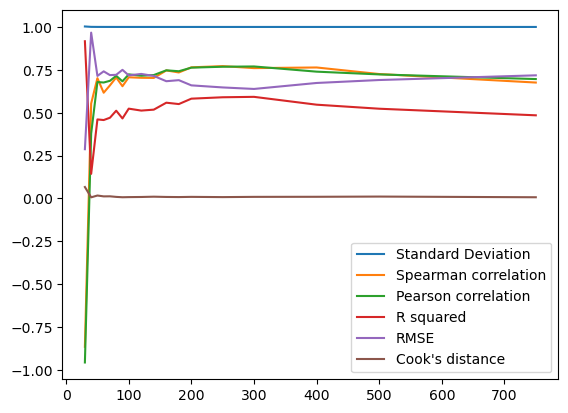

In [10]:
radii = [30,40,50,60,70,80,90,100,120,140,160,180,200,250,300,400,500,750]
mean_stats = {}

for radius in radii:
    data, std, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, y_pred = stats_multiple_times(radius, var, hiwn)
    mean_stats[radius] = {'std':std, 'spearman_corr': spearman_corr, 'p_value': p_value, 'pearson_corr': pearson_corr, 'r_squared': r_squared, 'rmse': rmse, 'cooks_d': cooks_d}

mean_stats = pd.DataFrame(mean_stats).T
plt.plot(radii, mean_stats['std'], label='Standard Deviation')
plt.plot(radii, mean_stats['spearman_corr'], label='Spearman correlation')
plt.plot(radii, mean_stats['pearson_corr'], label='Pearson correlation')
plt.plot(radii, mean_stats['r_squared'], label='R squared')
plt.plot(radii, mean_stats['rmse'], label='RMSE')
plt.plot(radii, mean_stats['cooks_d'], label="Cook's distance")
plt.legend()

In [43]:

radii = [30,40,50,60,70,80,90,100,120,140,160,180,200,250,300,400,500,750]
std_stats = {}

for radius in radii:
    std_stats[radius]={}
    for var in params:
        data, std, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, y_pred = stats_multiple_times(radius, var, hiwn)
        std_stats[radius][var] = std

std_stats = pd.DataFrame(std_stats).T

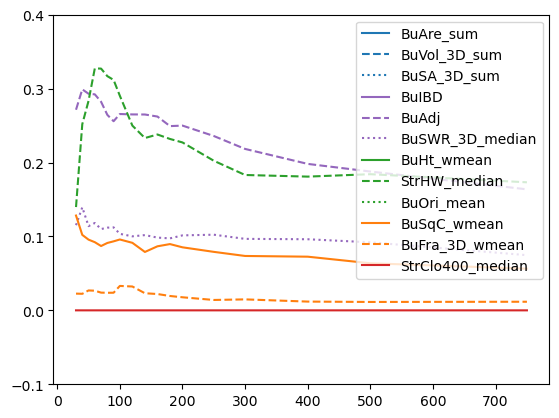

In [34]:
linestyle_mapping = {
    'BuAre_sum': '-',
    'BuVol_3D_sum': '--',
    'BuSA_3D_sum': ':',
    'BuIBD':'-',
    'BuAdj':'--',
    'BuSWR_3D_median':':',
    'BuHt_wmean': '-',
    'StrHW_median': '--',
    'BuOri_mean': ':',
    'BuSqC_wmean': '-',
    'BuFra_3D_wmean': '--',
    'StrClo400_median': '-'
}

color_mapping = {
    'BuAre_sum': 'tab:blue',
    'BuVol_3D_sum': 'tab:blue',
    'BuSA_3D_sum': 'tab:blue',
    'BuIBD':'tab:purple',
    'BuAdj':'tab:purple',
    'BuSWR_3D_median':'tab:purple',
    'BuHt_wmean': 'tab:green',
    'StrHW_median': 'tab:green',
    'BuOri_mean': 'tab:green',
    'BuSqC_wmean': 'tab:orange',
    'BuFra_3D_wmean': 'tab:orange',
    'StrClo400_median': 'tab:red'
}

for param in params:
    plt.plot(std_stats[param], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
    plt.legend()
    plt.ylim(-0.1,0.4)

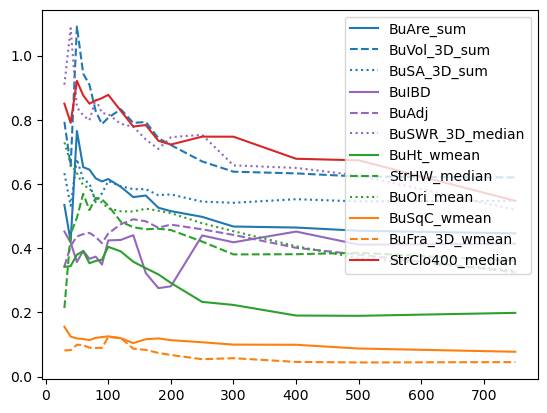

In [44]:
linestyle_mapping = {
    'BuAre_sum': '-',
    'BuVol_3D_sum': '--',
    'BuSA_3D_sum': ':',
    'BuIBD':'-',
    'BuAdj':'--',
    'BuSWR_3D_median':':',
    'BuHt_wmean': '-',
    'StrHW_median': '--',
    'BuOri_mean': ':',
    'BuSqC_wmean': '-',
    'BuFra_3D_wmean': '--',
    'StrClo400_median': '-'
}

color_mapping = {
    'BuAre_sum': 'tab:blue',
    'BuVol_3D_sum': 'tab:blue',
    'BuSA_3D_sum': 'tab:blue',
    'BuIBD':'tab:purple',
    'BuAdj':'tab:purple',
    'BuSWR_3D_median':'tab:purple',
    'BuHt_wmean': 'tab:green',
    'StrHW_median': 'tab:green',
    'BuOri_mean': 'tab:green',
    'BuSqC_wmean': 'tab:orange',
    'BuFra_3D_wmean': 'tab:orange',
    'StrClo400_median': 'tab:red'
}

for param in params:
    plt.plot(std_stats[param], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
    plt.legend()

In [19]:
def param_scale_plot(var):

    radii = [30,40,50,60,70,80,90,100,120,140,160,180,200,250,300,400,500,750]
    mean_stats = {}

    for radius in radii:
        data, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, y_pred = stats_multiple_times(radius, var, hiwn)
        mean_stats[radius] = {'spearman_corr': spearman_corr, 'p_value': p_value, 'pearson_corr': pearson_corr, 'r_squared': r_squared, 'rmse': rmse, 'cooks_d': cooks_d}

    fig = go.Figure()

    mean_stats = pd.DataFrame(mean_stats).T

    fig.add_trace(go.Scatter(x=radii, y=mean_stats['spearman_corr'], mode='lines', name='Spearman correlation'))
    fig.add_trace(go.Scatter(x=radii, y=mean_stats['pearson_corr'], mode='lines', name='Pearson correlation'))
    fig.add_trace(go.Scatter(x=radii, y=mean_stats['r_squared'], mode='lines', name='R squared'))
    fig.add_trace(go.Scatter(x=radii, y=mean_stats['rmse'], mode='lines', name='RMSE'))
    fig.add_trace(go.Scatter(x=radii, y=mean_stats['cooks_d'], mode='lines', name="Cook's distance"))

    fig.update_layout(title=var+' correlation and regression statistics across radii',
                        xaxis_title='Radius (m)',
                        yaxis_title='Value')
    fig.show()

In [46]:
def multiple_scales(vars):

    radii = [30,40,50,60,70,80,90,100,120,140,160,180,200,250,300,400,500,750]
    cv_stats = {}
    spearman_stats = {}
    p_value_stats = {}
    pearson_stats = {}
    rmse_stats = {}
    cooks_stats = {}
    
    for radius in radii:
        cv_stats[radius] = {}
        spearman_stats[radius] = {}
        p_value_stats[radius] = {}
        pearson_stats[radius] = {}
        rmse_stats[radius] = {}
        cooks_stats[radius] = {}
        
        for var in vars:
            data, CV, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, y_pred = stats_multiple_times(radius, var, hiwn)
            cv_stats[radius][var] = CV
            spearman_stats[radius][var] = spearman_corr
            p_value_stats[radius][var] = p_value
            pearson_stats[radius][var] = pearson_corr
            rmse_stats[radius][var] = rmse
            cooks_stats[radius][var] = cooks_d
            
    return cv_stats, spearman_stats, p_value_stats, pearson_stats, rmse_stats, cooks_stats

In [47]:
params = ['BuAre_sum', 'BuVol_3D_sum', 'BuSA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','BuOri_mean', 'BuSqC_wmean','BuFra_3D_wmean', 'StrClo400_median']

In [49]:
cv_stats, spearman_stats, p_value_stats, pearson_stats, rmse_stats, cooks_stats = multiple_scales(params)

In [50]:
cv_stats = pd.DataFrame(cv_stats).T
spearman_stats = pd.DataFrame(spearman_stats).T
p_value_stats = pd.DataFrame(p_value_stats).T
pearson_stats = pd.DataFrame(pearson_stats).T
rmse_stats = pd.DataFrame(rmse_stats).T
cooks_stats = pd.DataFrame(cooks_stats).T

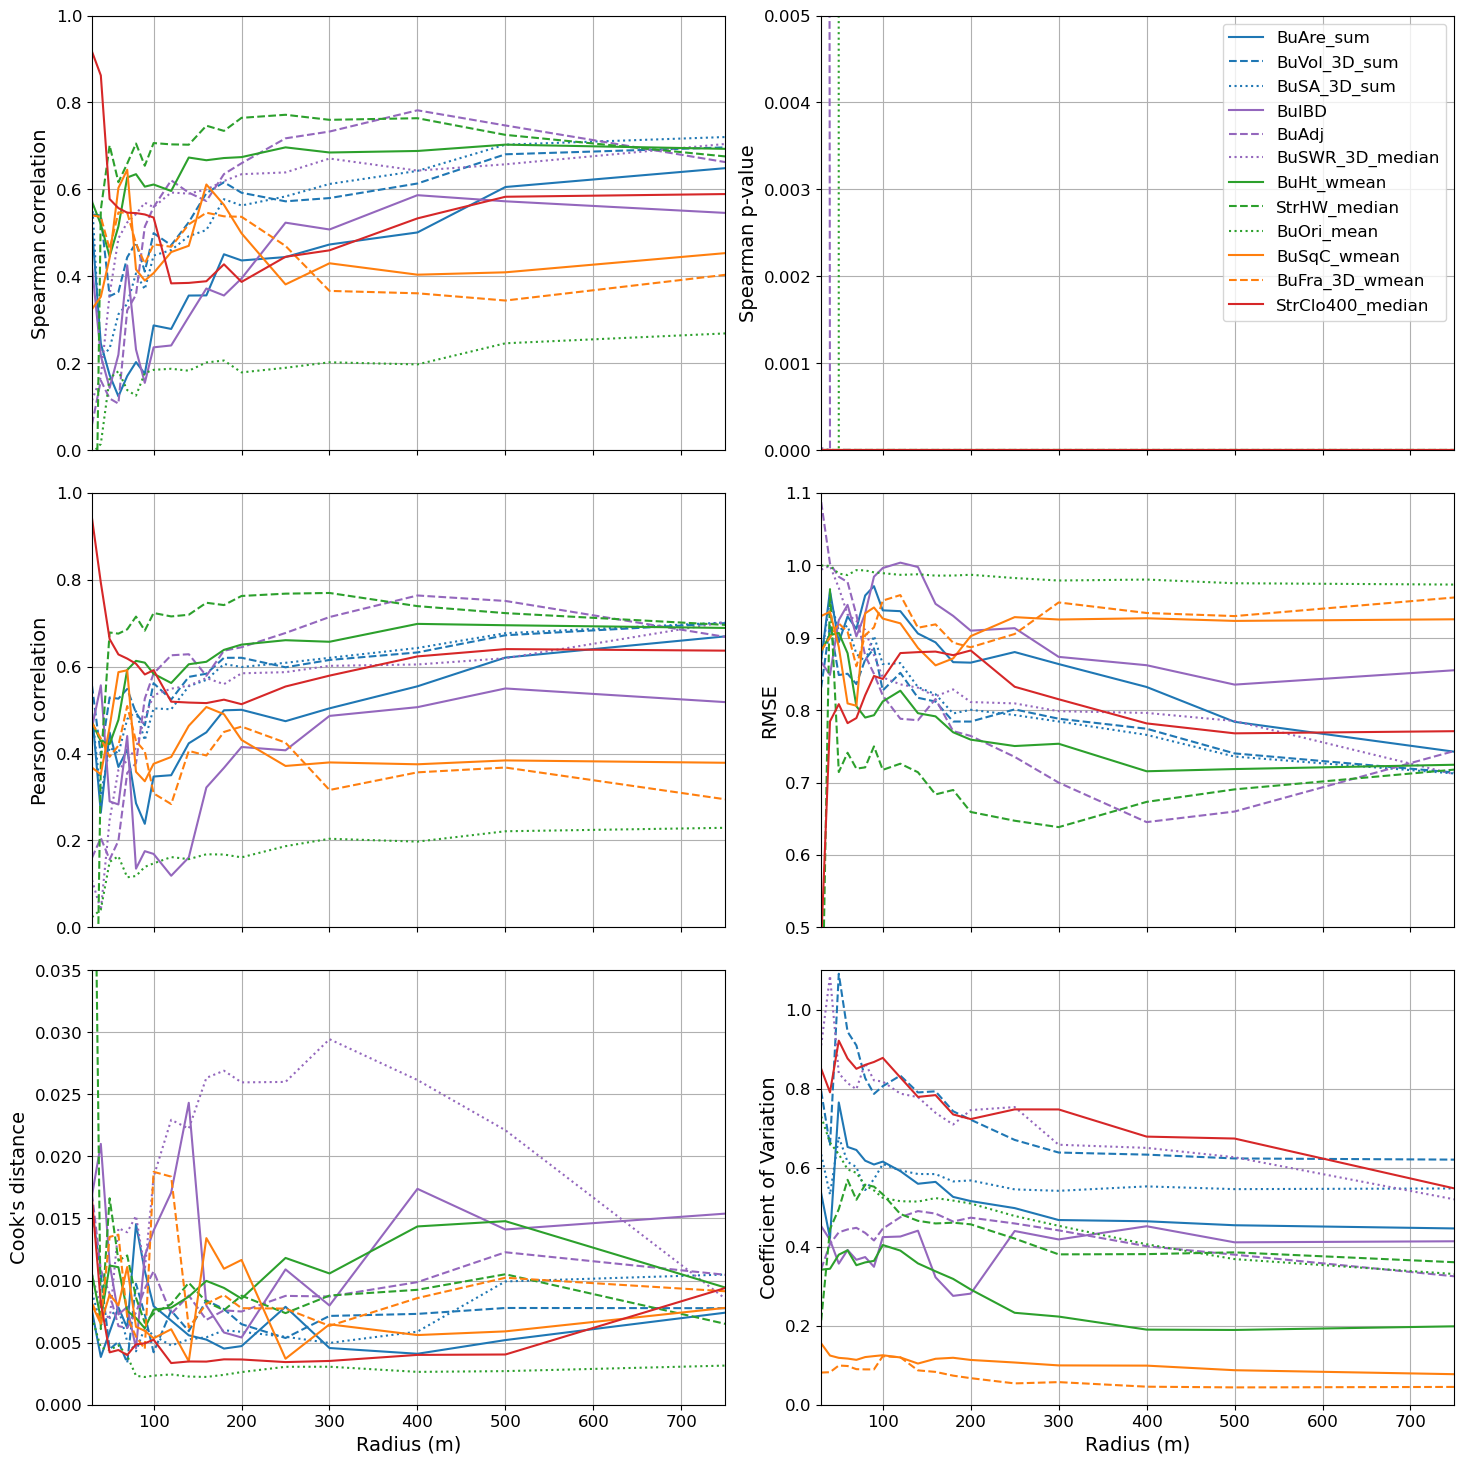

In [71]:
# make 4 subplots
fig, axs = plt.subplots(3,2, figsize=(15, 15))

linestyle_mapping = {
    'BuAre_sum': '-',
    'BuVol_3D_sum': '--',
    'BuSA_3D_sum': ':',
    'BuIBD':'-',
    'BuAdj':'--',
    'BuSWR_3D_median':':',
    'BuHt_wmean': '-',
    'StrHW_median': '--',
    'BuOri_mean': ':',
    'BuSqC_wmean': '-',
    'BuFra_3D_wmean': '--',
    'StrClo400_median': '-'
}

color_mapping = {
    'BuAre_sum': 'tab:blue',
    'BuVol_3D_sum': 'tab:blue',
    'BuSA_3D_sum': 'tab:blue',
    'BuIBD':'tab:purple',
    'BuAdj':'tab:purple',
    'BuSWR_3D_median':'tab:purple',
    'BuHt_wmean': 'tab:green',
    'StrHW_median': 'tab:green',
    'BuOri_mean': 'tab:green',
    'BuSqC_wmean': 'tab:orange',
    'BuFra_3D_wmean': 'tab:orange',
    'StrClo400_median': 'tab:red'
}

for param in params:
    axs[0, 0].plot(spearman_stats[param], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
axs[0, 0].set_ylabel('Spearman correlation', fontsize=14)
axs[0, 0].set_ylim(0, 1)
axs[0, 0].set_xlim(30, 750)
axs[0, 0].set_xticklabels([])
axs[0, 0].tick_params(axis='both', which='major', labelsize=12)
axs[0, 0].grid()

for param in params:
    axs[0, 1].plot(p_value_stats[param], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
axs[0, 1].set_ylabel("Spearman p-value", fontsize=14)
axs[0, 1].legend(prop={'size': 12})
axs[0, 1].set_ylim(0, 0.005)
axs[0, 1].set_xlim(30, 750)
axs[0, 1].set_xticklabels([])
axs[0, 1].tick_params(axis='both', which='major', labelsize=12)
axs[0, 1].grid()

for param in params:
    axs[1, 0].plot(pearson_stats[param], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
axs[1, 0].set_ylabel('Pearson correlation', fontsize=14)
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_xlim(30, 750)
axs[1, 0].set_xticklabels([])
axs[1, 0].tick_params(axis='both', which='major', labelsize=12)
axs[1, 0].grid()

for param in params:
    axs[1, 1].plot(rmse_stats[param], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
axs[1, 1].set_ylabel('RMSE', fontsize=14)
axs[1, 1].grid()
axs[1, 1].set_ylim(0.5, 1.1)
axs[1, 1].set_xlim(30, 750)
axs[1, 1].set_xticklabels([])
axs[1, 1].tick_params(axis='both', which='major', labelsize=12)

for param in params:
    axs[2, 0].plot(cooks_stats[param], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
axs[2, 0].set_ylabel("Cook's distance", fontsize=14)
axs[2, 0].set_ylim(0, 0.035)
axs[2, 0].set_xlim(30, 750)
axs[2, 0].set_xlabel('Radius (m)', fontsize=14)
axs[2, 0].tick_params(axis='both', which='major', labelsize=12)
axs[2, 0].grid()

for param in params:
    axs[2, 1].plot(cv_stats[param], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
axs[2, 1].set_ylabel("Coefficient of Variation", fontsize=14)
axs[2, 1].set_ylim(0, 1.1)
axs[2, 1].set_xlim(30, 750)
axs[2, 1].set_xlabel('Radius (m)', fontsize=14)
axs[2, 1].tick_params(axis='both', which='major', labelsize=12)
axs[2, 1].grid()

plt.tight_layout(pad = 2, w_pad=1)
plt.savefig('/Users/lisawink/Documents/paper1/figures/param_scale_plot_featured_list.png')
plt.show()

In [58]:
p_value_stats

,BuAre_sum,BuVol_3D_sum,BuSA_3D_sum,BuIBD,BuAdj,BuSWR_3D_median,BuHt_wmean,StrHW_median,BuOri_mean,BuSqC_wmean,BuFra_3D_wmean,StrClo400_median
30,2.729171e-91,7.575096e-105,1.197163e-120,3.878971e-16,1.017898e-01,2.369748e-05,9.808053e-119,1.876839e-52,7.649720e-01,1.003967e-34,7.129802e-104,6.415671e-103
40,1.108180e-24,2.962466e-129,4.547925e-19,3.199217e-13,2.887973e-10,3.077056e-12,3.468698e-118,8.889902e-56,5.569148e-01,5.064233e-51,2.222582e-127,3.685033e-152
50,1.444222e-14,7.093988e-59,1.203955e-25,7.355939e-09,2.567405e-07,3.792755e-60,4.026280e-96,7.704978e-177,1.760987e-13,1.735231e-94,2.096673e-104,2.099962e-99
60,1.085766e-08,1.588629e-67,2.263448e-49,7.296669e-22,2.150682e-06,5.004889e-127,3.929062e-144,5.318243e-152,3.600714e-17,5.407209e-211,4.300320e-166,2.494310e-125
70,2.040356e-16,3.115070e-111,7.529776e-62,5.992598e-94,1.963455e-54,5.721730e-162,2.703981e-251,1.560321e-212,3.060565e-11,2.240954e-270,1.026780e-178,2.306047e-126
80,3.150866e-24,1.069383e-140,9.197182e-99,2.942923e-28,3.613483e-70,3.109796e-189,2.239049e-278,4.414962e-307,4.410729e-10,1.236413e-103,4.131596e-139,2.019383e-145
90,4.025506e-19,2.223516e-104,1.726870e-83,1.129251e-14,4.306561e-172,5.872807e-219,8.435262e-256,5.331963e-260,1.779305e-19,1.683229e-93,8.145148e-115,2.582009e-156
100,4.104547e-51,4.041637e-166,4.772007e-130,9.461996e-34,1.263147e-209,1.190693e-216,1.060016e-269,0.000000e+00,1.206046e-21,7.291800e-106,2.429143e-147,8.422282e-158
120,3.084993e-48,5.478048e-146,2.461852e-138,5.896954e-35,1.342785e-271,9.112855e-250,1.349364e-253,0.000000e+00,3.389007e-22,2.936919e-135,1.700379e-143,2.512121e-84
140,2.137210e-79,3.752828e-186,5.623166e-161,9.717475e-57,1.615144e-241,3.778620e-247,0.000000e+00,0.000000e+00,3.315711e-21,4.587834e-145,4.358714e-182,7.870974e-85


In [36]:
def plot_scales(vars):

    spearman_stats, p_value_stats, pearson_stats, rmse_stats, cooks_stats = multiple_scales(vars)

    spearman_stats = pd.DataFrame(spearman_stats).T
    p_value_stats = pd.DataFrame(p_value_stats).T
    pearson_stats = pd.DataFrame(pearson_stats).T
    rmse_stats = pd.DataFrame(rmse_stats).T
    cooks_stats = pd.DataFrame(cooks_stats).T

    # make 4 subplots
    fig, axs = plt.subplots(2,2, figsize=(10, 15))

    axs[0, 0].plot(spearman_stats)
    axs[0, 0].set_title('Spearman correlation')
    axs[0, 0].legend(vars)

    axs[0, 1].plot(pearson_stats)
    axs[0, 1].set_title('Pearson correlation')
    axs[0, 1].legend(vars)

    axs[1, 0].plot(rmse_stats)
    axs[1, 0].set_title('RMSE')
    axs[1, 0].legend(vars)

    axs[1, 1].plot(cooks_stats)
    axs[1, 1].set_title("Cook's distance")
    axs[1, 1].legend(vars)

    plt.show()

In [18]:
import warnings

warnings.filterwarnings('ignore')

In [21]:
param_scale_plot('BuAre_sum')

In [22]:
param_scale_plot('BuVol_3D_sum')

In [24]:
param_scale_plot('BuSA_3D_sum')

In [25]:
param_scale_plot('BuIBD')

In [26]:
param_scale_plot('BuAdj')

In [27]:
param_scale_plot('BuSWR_3D_sum')

In [28]:
param_scale_plot('BuHt_wmean')

In [29]:
param_scale_plot('StrHW_median')

In [30]:
param_scale_plot('BuOri_mean')

In [31]:
param_scale_plot('BuSqC_wmean')

In [32]:
param_scale_plot('BuFra_3D_wmean')

In [33]:
param_scale_plot('StrClo400_median')

put all spearman correlation in one plot, colour by type, use dashed lines and what not